In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import torch

In [6]:
from dataclasses import dataclass
import torch.nn as nn

@dataclass
class HarmonicSpheres:
    weights: list[int]
    spheres: torch.Tensor
    weights: torch.Tensor

    def __init__(self, npoints=100):
        phi = np.linspace(0, np.pi, npoints)
        theta = np.linspace(0, 2*np.pi, npoints)
        phi, theta = np.meshgrid(phi, theta)
        self.x = np.sin(phi) * np.cos(theta)
        self.y = np.sin(phi) * np.sin(theta)
        self.z = np.cos(phi)

        self.weights = torch.rand((3, 9))

        self.spheres = torch.empty((9, npoints, npoints))

        harmonic_cf = [[0, 0], [1, 1], [0, 1], [-1, 1], [2, 2], [1, 2], [0,2], [-1, 2], [-2, 2]]
        for i, [m, l] in enumerate(harmonic_cf):
            self.spheres[i, :, :] = torch.tensor(sph_harm(m, l, theta, phi).real)

    def get_total(self):
        weights = self.weights
        npoints = self.spheres.shape[1]

        res = torch.ones((npoints, npoints, 4))
        res[:, :, :3] = (weights @ self.spheres.reshape((9, npoints*npoints))).T.reshape(npoints, npoints, 3)
        res = res.clamp(min=0, max=1)
        return res

    def get_cartesian(self):
        return self.x, self.y, self.z

In [7]:
# input: point on the sphere (theta, phi)
# output: color (rgba)

import torch.nn as nn

class SphereNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spheres = HarmonicSpheres()
        self.weights = nn.Parameter(self.spheres.weights, requires_grad=True)
        self.npoints = self.spheres.spheres.shape[1]

    def forward(self):
        spheres = self.spheres.spheres
        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (self.weights @ spheres.view((9, self.npoints*self.npoints))).T.view(self.npoints, self.npoints, 3)
        
        res = res.clamp(min=0, max=1)
        return res

In [44]:
import torch.optim as optim

spheres = HarmonicSpheres(100)
spheres.weights[0, :] = torch.tensor([1, 0, 1, 0, 0, 0, 0, 0, 0])
spheres.weights[1, :] = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0])
spheres.weights[2, :] = torch.tensor([0, 0, 1, 0, 0, 0, 1, 0, 0])

target = spheres.get_total()

model = SphereNet()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
epochs = 3000

for epoch in range(epochs):
    optimizer.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss.item())


0.030485769733786583
0.00799955241382122
0.002468364778906107
0.0010541359661146998
0.0006056323763914406
0.00040179991628974676
0.000287080358248204
0.00021405020379461348
0.00016396844875998795
0.00012805830920115113
0.0001013107321341522
8.101664570858702e-05
6.534010753966868e-05
5.3070325520820916e-05
4.337356222094968e-05
3.559957622201182e-05
2.9307273507583886e-05
2.422864781692624e-05
2.011682045122143e-05
1.677810178080108e-05
1.4053375707590021e-05
1.1814555364253465e-05
9.969010534405243e-06
8.441113095614128e-06
7.165038368839305e-06
6.102662609919207e-06
5.2187556320859585e-06
4.4820094444730785e-06
3.867356099362951e-06
3.3540836739121005e-06


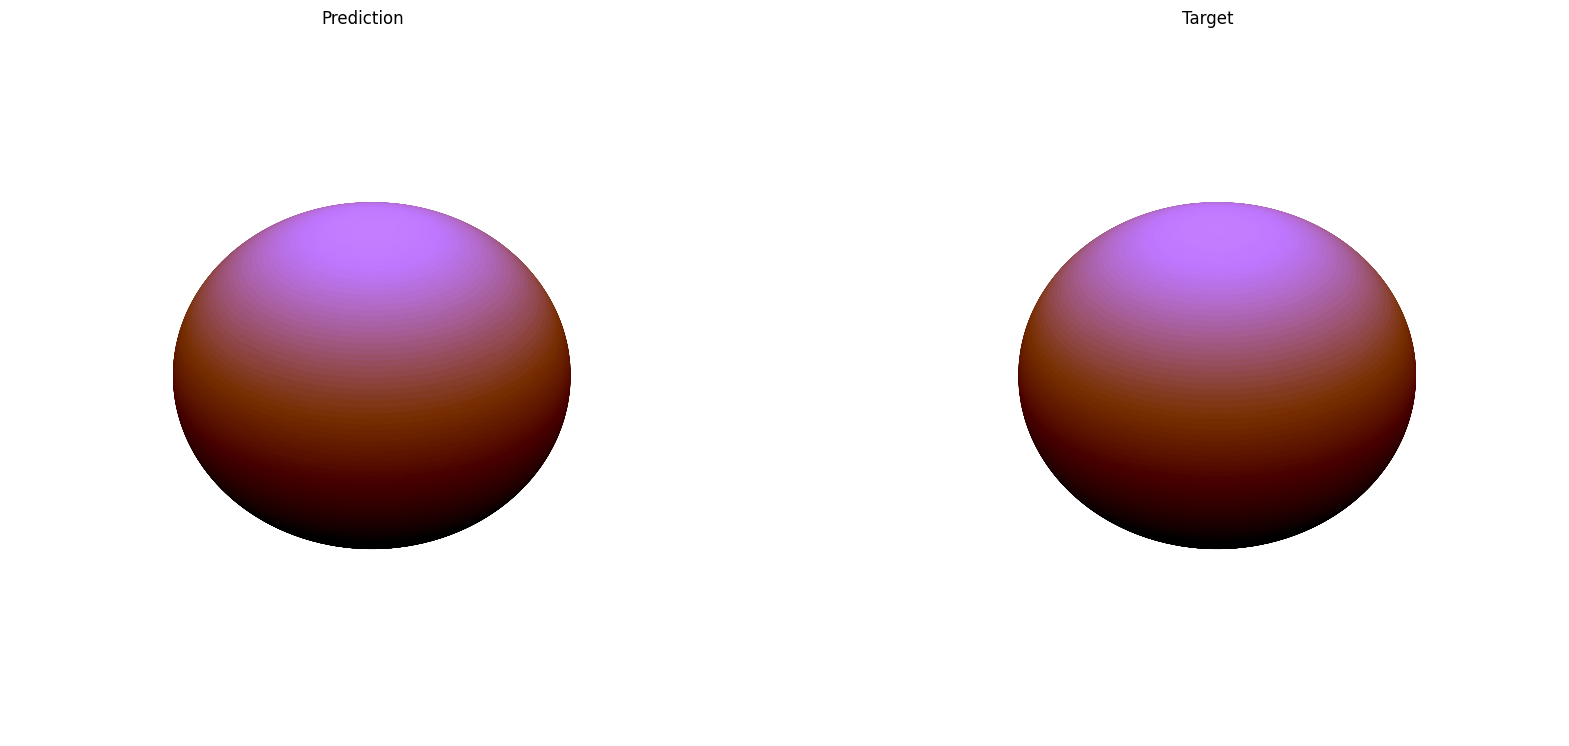

In [45]:
predcolors = model.spheres.get_total().numpy()
targcolors = spheres.get_total().numpy()
x,y,z = spheres.get_cartesian()


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

# Equal harmonics, different orientation

This problem could be solved by calculating rotation-invariant properties of every plenoxel after the initial training phase. (Basically 'resetting' their orientation).

The following part is a bit messy, but I hope you get the point. In the end, I compare the frequency domains of the sampled colors of similar and dissimilar plenoxels. Using this, we can compare plenoxels with different orientations!

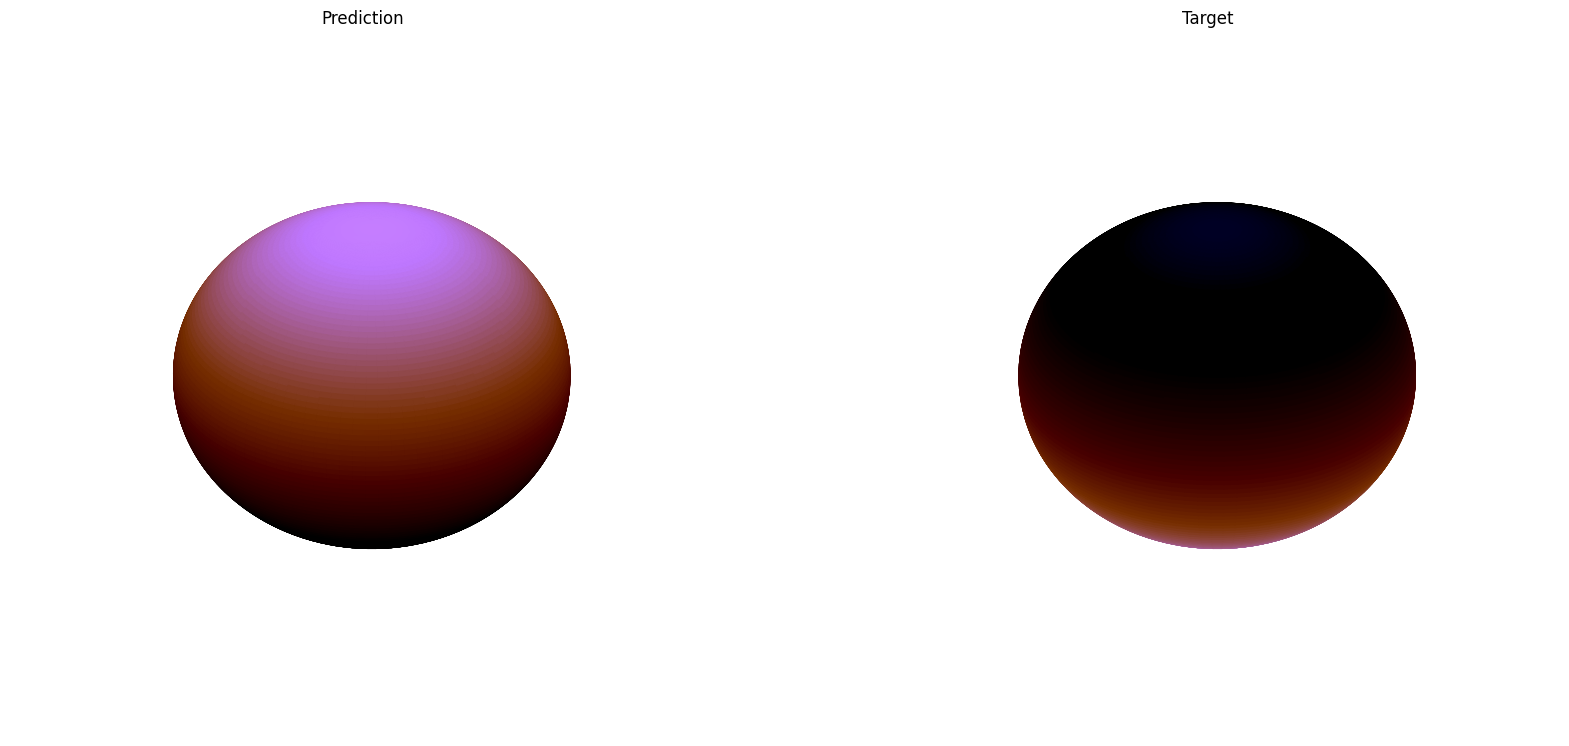

In [46]:
# rotating a sphere

Ry = lambda theta : np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0 , np.cos(theta)],
])
Rx = lambda theta : np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)],
])

#original_coords = np.array([x,y,z]).reshape(3, 100*100)
target = spheres.get_total()
target = torch.flip(target.view(100*100, 4), dims=[0]).view(100,100,4)
# targcolors = target.numpy()
# Goal; get the new colors in the basis orientation

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=model.spheres.get_total().numpy(), shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=target.numpy(), shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

In [47]:
# Can we learn rcoords?
model = SphereNet()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
epochs = 3000

for epoch in range(epochs):
    optimizer.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss.item())

0.19315411150455475
0.017625434324145317
0.007056412287056446
0.004302654415369034
0.0022521086502820253
0.0009699060465209186
0.00044573177001439035
0.00025065289810299873
0.00016894450527615845
0.000127528837765567
0.0001024340745061636
8.520574920112267e-05
7.256442040670663e-05
6.293637852650136e-05
5.540862548514269e-05
4.9401445721741766e-05
4.455358430277556e-05
4.0617633203510195e-05
3.740551619557664e-05
3.477022983133793e-05
3.259252480347641e-05
3.0772229365538806e-05
2.923100328189321e-05
2.7911451979889534e-05
2.6772742785396986e-05
2.5783783712540753e-05
2.4919032512116246e-05
2.4157456209650263e-05
2.3481752577936277e-05
2.287766255903989e-05


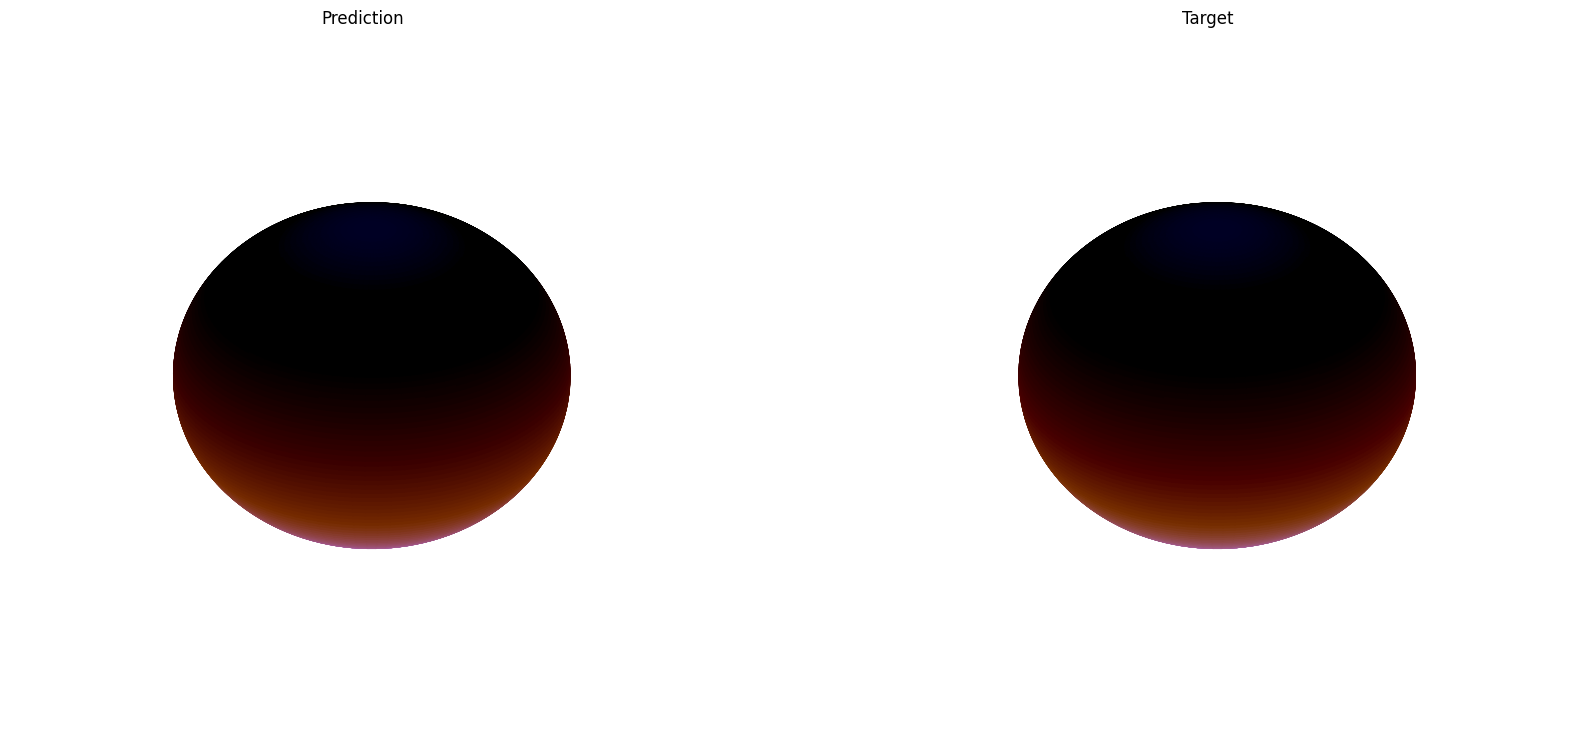

tensor([[ 1.0000,  0.5940, -1.0000,  0.5940, -0.1170,  0.4040, -0.0000,  0.4040,
          0.1170],
        [ 0.3000,  0.3610, -0.6450,  0.3590,  0.1340,  0.5670,  0.1600,  0.5660,
         -0.1340],
        [ 0.0230,  0.6940, -0.9930,  0.6900,  0.2530,  0.8560,  0.9850,  0.8530,
         -0.2520]])
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0.]])


In [48]:
predcolors = model.spheres.get_total().numpy()
targcolors = target.numpy()
x,y,z = spheres.get_cartesian()


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

print((model.spheres.weights *1000).round()/1000)
print(spheres.weights)

In [75]:
# The following spherical harmonic frequencies are similar,
# but have different weights.
# tensor([[ 1.0000,  0.1710, -0.9990,  0.1710, -0.1340,  0.5460,  0.0000,  0.5460,0.1340],
#         [ 0.2490,  0.7760, -0.7070,  0.7880, -0.0130,  0.7070,  0.1320,  0.7170, 0.0120],
#         [ 0.0050,  0.6250, -0.9980,  0.6300,  0.0470,  0.4170,  0.9970,  0.4200,-0.0420]])
# tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 1., 0., 0., 0., 1., 0., 0.]])

# Note that these two spheres have the same frequency domain.
# How can we convert these to the same? -> Fourier analysis on the colors?
predcol = model.spheres.get_total().view(100*100, 4)[:10000, :3]
targcol = spheres.get_total().view(100*100, 4)[:10000, :3]
predfft = torch.fft.fft(predcol, dim=1)
targfft = torch.fft.fft(targcol, dim=1)

whitesphere = HarmonicSpheres()
# This is the representation of a pure white sphere.
whitesphere.weights = torch.tensor([[ 3.5768,  0.7600,  0.0081,  0.7588,  0.1288,  0.5222,  0.0280,  0.5151,
         -0.1284],
        [ 3.5736,  0.3626,  0.0148,  0.3650, -0.4068,  0.7502,  0.0237,  0.7568,
          0.4072],
        [ 3.5731,  0.2528,  0.0106,  0.2553, -0.1333,  0.5424,  0.0236,  0.5521,
          0.1341]])
blacksphere = HarmonicSpheres()
# Pure black sphere
blacksphere.weights = torch.zeros((3, 9))
whitefft = torch.fft.fft(whitesphere.get_total().view(100*100, 4)[:10000, :3], dim = 1)
blackfft = torch.fft.fft(blacksphere.get_total().view(100*100, 4)[:10000, :3], dim = 1)

# plt.plot(predcol)
# plt.plot(targcol)

diff = abs((predfft-targfft).mean(dim=0)).sum() / 3
diff2 = abs((predfft-whitefft).mean(dim=0)).sum() / 3
diff3 = abs((whitefft - blackfft)).mean(dim=0).sum() / 3
print(f"Similar spheres: {diff}")
print(f"Dissimilar spheres: {diff2}")
print(f"Opposite spheres (should be 1): {diff3}")

Similar spheres: 0.0006153606227599084
Dissimilar spheres: 0.8491451144218445
Opposite spheres (should be 1): 1.000001311302185
